<a href="https://colab.research.google.com/github/LPValente/TensorFlow2.0/blob/main/TF2_0_Stock_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
print(tf.__version__)

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-beta1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-beta1
2.12.0


In [2]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
# yes, you can read dataframes from URLs!
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [5]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [6]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [7]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [8]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [9]:
## try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.1)
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 4s 60ms/step - loss: 0.0904 - val_loss: 0.0731
Epoch 2/80
20/20 [==============================] - 0s 16ms/step - loss: 0.0139 - val_loss: 0.0496
Epoch 3/80
20/20 [==============================] - 0s 16ms/step - loss: 0.0085 - val_loss: 0.0266
Epoch 4/80
20/20 [==============================] - 0s 16ms/step - loss: 0.0065 - val_loss: 0.0230
Epoch 5/80
20/20 [==============================] - 0s 14ms/step - loss: 0.0066 - val_loss: 0.0172
Epoch 6/80
20/20 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0281
Epoch 7/80
20/20 [==============================] - 0s 19ms/step - loss: 0.0054 - val_loss: 0.0287
Epoch 8/80
20/20 [==============================] - 0s 21ms/step - loss: 0.0059 - val_loss: 0.0380
Epoch 9/80
20/20 [==============================] - 0s 21ms/step - loss: 0.0067 - val_loss: 0.0700
Epoch 10/80
20/20 [==============================] - 0s 24ms/step - loss: 0.0070 - val_loss: 0.0213
Epoch 11/

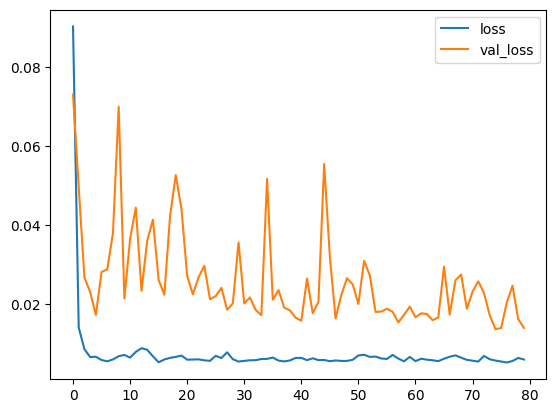

In [10]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

40/40 [==============================] - 1s 3ms/step
(1249, 1)


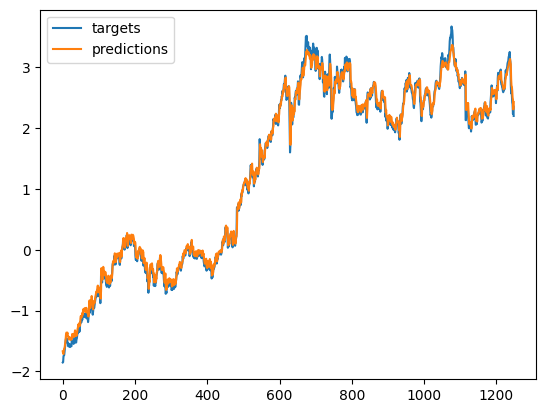

In [11]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 20ms/step


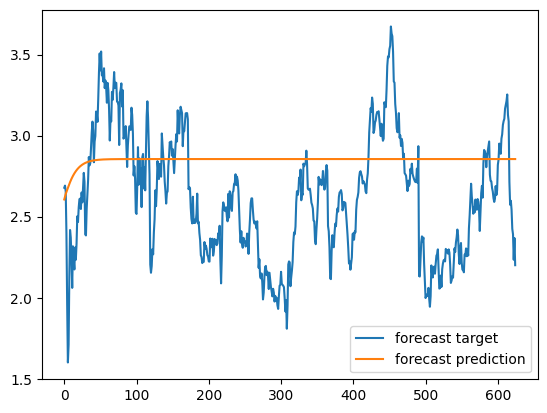

In [12]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [13]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [14]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [15]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [16]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


<Axes: >

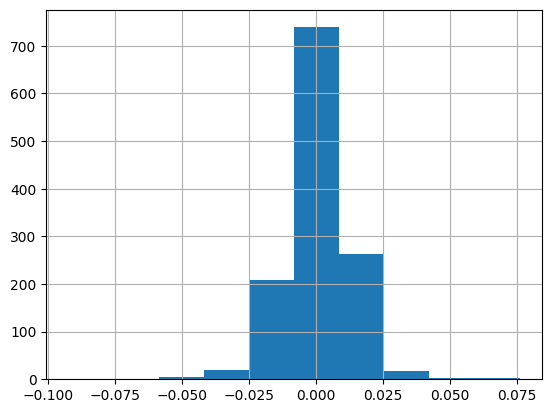

In [17]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [18]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [19]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [20]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.1),
)

#train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 3s 41ms/step - loss: 1.0159 - val_loss: 1.1294
Epoch 2/80
20/20 [==============================] - 0s 13ms/step - loss: 1.0052 - val_loss: 1.1457
Epoch 3/80
20/20 [==============================] - 0s 12ms/step - loss: 1.0090 - val_loss: 1.1317
Epoch 4/80
20/20 [==============================] - 0s 13ms/step - loss: 0.9950 - val_loss: 1.1463
Epoch 5/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9783 - val_loss: 1.2354
Epoch 6/80
20/20 [==============================] - 0s 13ms/step - loss: 0.9895 - val_loss: 1.1493
Epoch 7/80
20/20 [==============================] - 0s 13ms/step - loss: 0.9867 - val_loss: 1.2269
Epoch 8/80
20/20 [==============================] - 0s 12ms/step - loss: 0.9975 - val_loss: 1.1657
Epoch 9/80
20/20 [==============================] - 0s 12ms/step - loss: 0.9671 - val_loss: 1.2364
Epoch 10/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9647 - val_loss: 1.1968
Epoch 11/

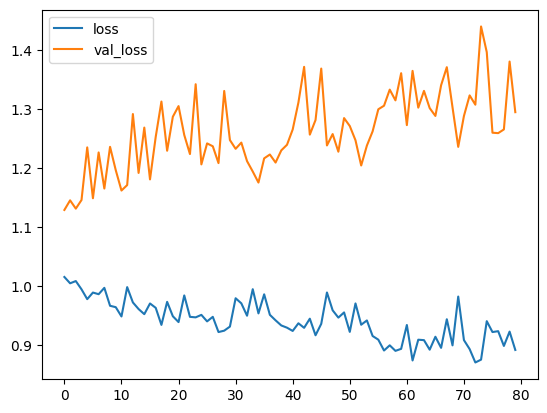

In [21]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

39/39 [==============================] - 1s 2ms/step
(1248, 1)


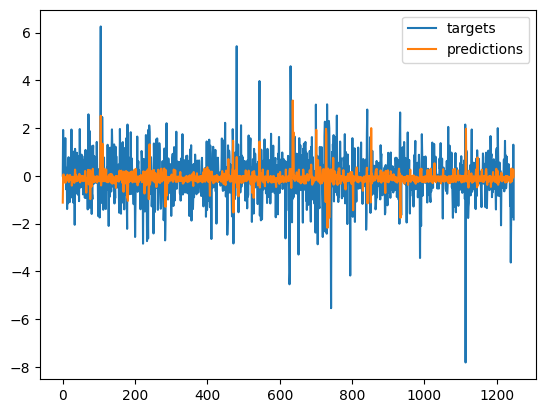

In [22]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 26ms/step


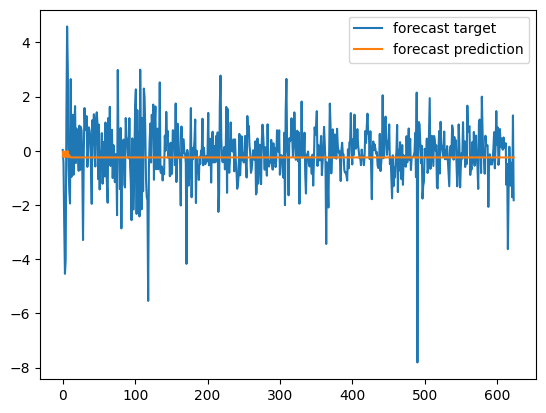

In [23]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [38]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [39]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 1l data points then you'd only have 1 sample)

In [40]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain+T])
input_data = scaler.transform(input_data)

In [41]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T]>0)

In [42]:
# Setup X_test and Y_test
X_test = np.zeros((N-Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
  # u counts from 0...(N-Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [43]:
# make the RNN
i = Input(shape=(T,D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

In [44]:
# train the RNN
r = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=300,
    validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 3s 28ms/step - loss: 0.6943 - accuracy: 0.4934 - val_loss: 0.6964 - val_accuracy: 0.4780
Epoch 2/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6967 - accuracy: 0.4923 - val_loss: 0.6951 - val_accuracy: 0.4829
Epoch 3/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6924 - accuracy: 0.5447 - val_loss: 0.6941 - val_accuracy: 0.4805
Epoch 4/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6907 - accuracy: 0.5304 - val_loss: 0.6949 - val_accuracy: 0.4902
Epoch 5/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6910 - accuracy: 0.5256 - val_loss: 0.6951 - val_accuracy: 0.4902
Epoch 6/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6905 - accuracy: 0.5316 - val_loss: 0.6953 - val_accuracy: 0.4927
Epoch 7/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6894 - accuracy: 0.5364 - val_loss: 0.6960 - val_accuracy: 0.4927
Epoch 8/300

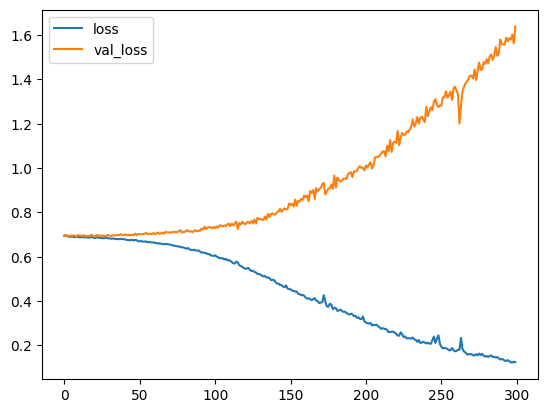

In [45]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

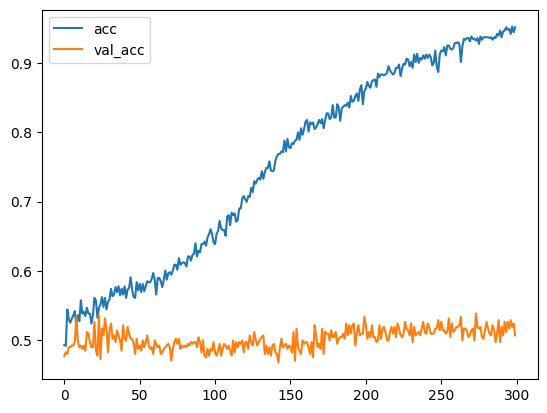

In [46]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()